In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
# from ROI_extraction import preprocess_image
import cv2
import os
# Set the path to dataset
dataset_path = '../images/3regimes/'

ids = []
labels = {}
classes = {'excess':1,'normal':0,'insufficient':2}
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for filename in os.listdir(class_path) :
            if filename.endswith((".jpg", ".jpeg", ".png")):
                img_path = os.path.join(class_path, filename) 
                ids.append(img_path)
                labels[img_path]=classes[class_name]

# Set the input image dimensions
img_width, img_height = 800, 800
n_channels = 3

params = {'dim': (img_height,img_width),
          'batch_size': 64,
          'n_classes': 3,
          'n_channels': n_channels,
          'shuffle': False}

# Set the number of classes
num_classes = 3

def data_generation(list_IDs_temp):
    y = np.empty((len(list_IDs_temp)), dtype=int)
    X = []
    for i, ID in enumerate(list_IDs_temp):
        img= cv2.imread(ID)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        H_val,S_val,V_val = img[:,:,0],img[:,:,1],img[:,:,2]
        # Extract the mean values of hue, saturation, and value
        H_mean = np.mean(H_val)
        S_mean = np.mean(S_val)
        V_mean = np.mean(V_val)
        # Extract the standard deviation of hue, saturation, and value
        H_std = np.std(H_val)
        S_std = np.std(S_val)
        V_std = np.std(V_val)
        # Extract the contrast values of hue, saturation, and value
        # H_max,S_max,V_max = np.max(H_val),np.max(S_val),np.max(V_val)
        # H_min,S_min,V_min = np.min(H_val),np.min(S_val),np.min(V_val)
        # H_contrast = (H_max - H_min) / (H_max + H_min)
        # S_contrast = (S_max - S_min) / (S_max + S_min)
        # V_contrast = (V_max - V_min) / (V_max + V_min)
        X.append([H_mean,H_std,S_mean,S_std,V_mean,V_std])
        y[i] = labels[ID]
    return pd.DataFrame(X,columns=['H_mean','H_std','S_mean','S_std','V_mean','V_std']),keras.utils.to_categorical(y, num_classes=params['n_classes']),y


In [2]:
X,y_categorical,y = data_generation(ids)

In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
# Nombre de plis pour la validation croisée k-fold
k = 5

# Créer une instance de StratifiedKFold avec k plis
skf = StratifiedKFold(n_splits=k)


In [12]:
type(X)

pandas.core.frame.DataFrame

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
results = {i:{} for i in range(k)}

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

    # Diviser les données d'entraînement et de validation pour ce pli
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y[train_index], y[test_index]

    #train clustering algorithm
    kmeans = KMeans(n_clusters=3, random_state=0)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)

    kmeans.fit(X_train)
    y_train_pred = kmeans.labels_

    cm = confusion_matrix(y_train, y_train_pred)
    print("Matrice de confusion train {i} :")
    print(cm)

    X_val = scaler.fit_transform(X_val)

    #val
    y_val_pred = kmeans.predict(X_val)
    cm = confusion_matrix(y_val, y_val_pred)
    print("Matrice de confusion val {i} :")
    print(cm)


    results[i]['X_train']=X_train
    results[i]['X_val']=X_val
    results[i]['y_train']=y_train
    results[i]['y_train_pred']=y_train_pred
    results[i]['y_val']=y_val
    results[i]['y_val_pred']=y_val_pred


Fold 0:
  Train: index=[ 334  335  336 ... 5007 5008 5009]
  Test:  index=[   0    1    2 ... 3671 3672 3673]
Matrice de confusion train {i} :
[[1336    0    0]
 [   0 1212  124]
 [   0  593  743]]
Matrice de confusion val {i} :
[[334   0   0]
 [  0 298  36]
 [  0 116 218]]
Fold 1:
  Train: index=[   0    1    2 ... 5007 5008 5009]
  Test:  index=[ 334  335  336 ... 4005 4006 4007]
Matrice de confusion train {i} :
[[1336    0    0]
 [   0 1095  241]
 [   0  516  820]]
Matrice de confusion val {i} :
[[334   0   0]
 [  0 309  25]
 [  0  84 250]]
Fold 2:
  Train: index=[   0    1    2 ... 5007 5008 5009]
  Test:  index=[ 668  669  670 ... 4339 4340 4341]
Matrice de confusion train {i} :
[[   0 1336    0]
 [ 175    0 1161]
 [ 661    0  675]]
Matrice de confusion val {i} :
[[  0 334   0]
 [  0   0 334]
 [275   0  59]]
Fold 3:
  Train: index=[   0    1    2 ... 5007 5008 5009]
  Test:  index=[1002 1003 1004 ... 4673 4674 4675]
Matrice de confusion train {i} :
[[   0 1336    0]
 [1240    0   

d:\Programmes\miniconda3\envs\env_master_project\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\Programmes\miniconda3\envs\env_master_project\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\Programmes\miniconda3\envs\env_master_project\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\Programmes\miniconda3\envs\env_master_project\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly t

Matrice de confusion train {i} :
[[   0 1336    0]
 [1234    0  102]
 [ 591    0  745]]
Matrice de confusion val {i} :
[[  0 334   0]
 [297   0  37]
 [173   0 161]]


C:\Users\nrozo\AppData\Local\Temp\ipykernel_5664\444324098.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(tsne_transformed[results[0]['y_train'] == i, 0],


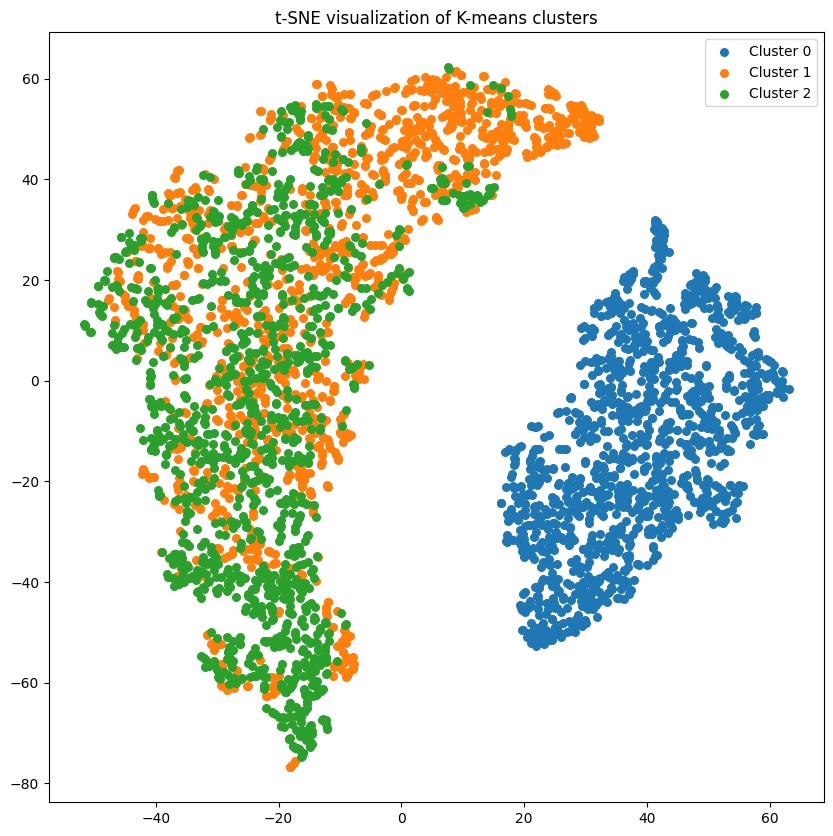

In [11]:
from sklearn.manifold import TSNE
# Use t-SNE to visualize the clusters
tsne = TSNE(n_components=2, random_state=0)
tsne_transformed = tsne.fit_transform(results[0]['X_train'])

# Plot the clusters
plt.figure(figsize=(10, 10))
colors = plt.cm.tab10(np.linspace(0, 1, 10))
for i in range(3):
    plt.scatter(tsne_transformed[results[0]['y_train'] == i, 0],
                tsne_transformed[results[0]['y_train'] == i, 1],
                s=30, c=colors[i], label='Cluster %d' % i)
plt.legend()
plt.title('t-SNE visualization of K-means clusters')
plt.show()

In [44]:
colors_bis = [colors[1],colors[2],colors[0]]


C:\Users\nrozo\AppData\Local\Temp\ipykernel_5664\2261383056.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(tsne_transformed[results[0]['y_train_pred'] == i, 0],


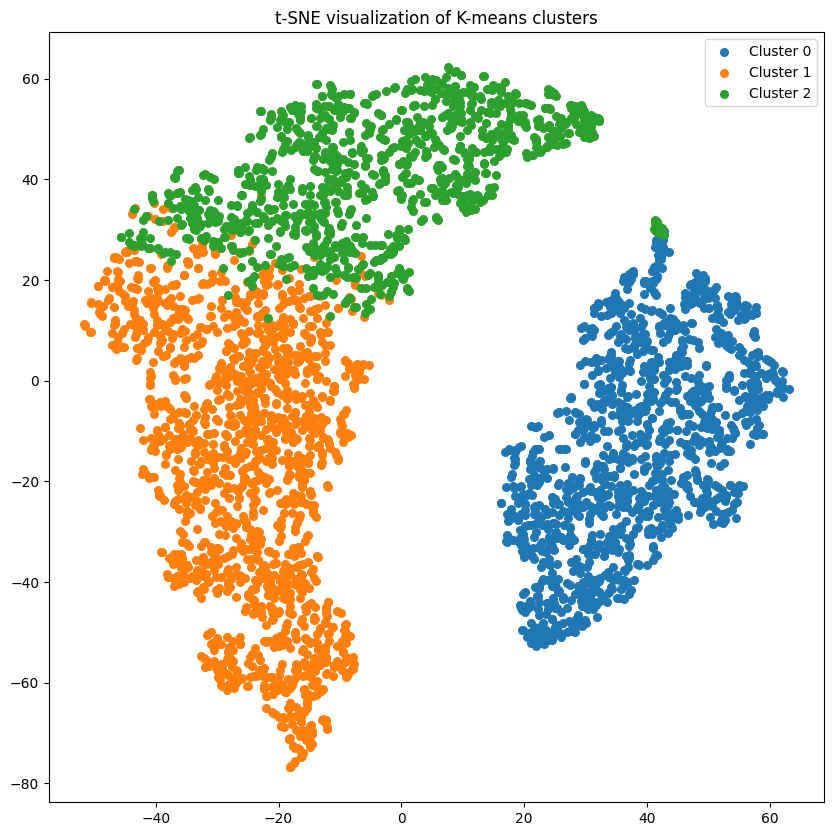

In [12]:
from sklearn.manifold import TSNE
# Use t-SNE to visualize the clusters
tsne = TSNE(n_components=2, random_state=0)
tsne_transformed = tsne.fit_transform(results[0]['X_train'])

# Plot the clusters
plt.figure(figsize=(10, 10))
colors = plt.cm.tab10(np.linspace(0, 1, 10))
for i in range(3):
    plt.scatter(tsne_transformed[results[0]['y_train_pred'] == i, 0],
                tsne_transformed[results[0]['y_train_pred'] == i, 1],
                s=30, c=colors[i], label='Cluster %d' % i)
plt.legend()
plt.title('t-SNE visualization of K-means clusters')
plt.show()

In [56]:
print("Bons classements des images regime 'normal' :",cm[0][2]/len(y_val_argmax[y_val_argmax==0]))
print("Bons classements des images regime 'insufficient' :",cm[2][1]/len(y_val_argmax[y_val_argmax==0]))
print("Bons classements des images regime 'excess' :",cm[1][0]/len(y_val_argmax[y_val_argmax==0]))

Bons classements des images regime 'normal' : 0.9837067209775967
Bons classements des images regime 'insufficient' : 0.7617107942973523
Bons classements des images regime 'excess' : 0.6558044806517311
